<a href="https://colab.research.google.com/github/MarcFriz/Kaggle-PUBG_Finish_Placement_Prediction/blob/master/Kaggle_PUBG_Finish_Placement_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![PUBG Finish Placement Prediction](https://storage.googleapis.com/kaggle-competitions/kaggle/10335/logos/header.png)

#Step 1 - Install and Import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import os

import xgboost

# Step 2 - Import Dataset from Kaggle

In [2]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
#download 
!kaggle competitions download -c pubg-finish-placement-prediction

 30% 5.00M/16.9M [00:00<00:01, 8.71MB/s]
100% 16.9M/16.9M [00:00<00:00, 26.6MB/s]
 86% 85.0M/98.3M [00:01<00:00, 34.1MB/s]
100% 98.3M/98.3M [00:01<00:00, 53.7MB/s]
 94% 225M/239M [00:04<00:00, 52.2MB/s]
100% 239M/239M [00:04<00:00, 60.8MB/s]


In [4]:
#unzip training data 
# !ls
!unzip train_V2.csv.zip
!unzip test_V2.csv.zip
# !unzip sample_submission_V2.csv.zip
!ls

Archive:  train_V2.csv.zip
  inflating: train_V2.csv            
Archive:  test_V2.csv.zip
  inflating: test_V2.csv             
sample_data		      test_V2.csv      train_V2.csv
sample_submission_V2.csv.zip  test_V2.csv.zip  train_V2.csv.zip


#Step 3 - Exploratory Data Analysis

In [2]:
train = pd.read_csv('train_V2.csv')
# test = pd.read_csv('test_V2.csv')
train.shape

(4446966, 29)

In [0]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


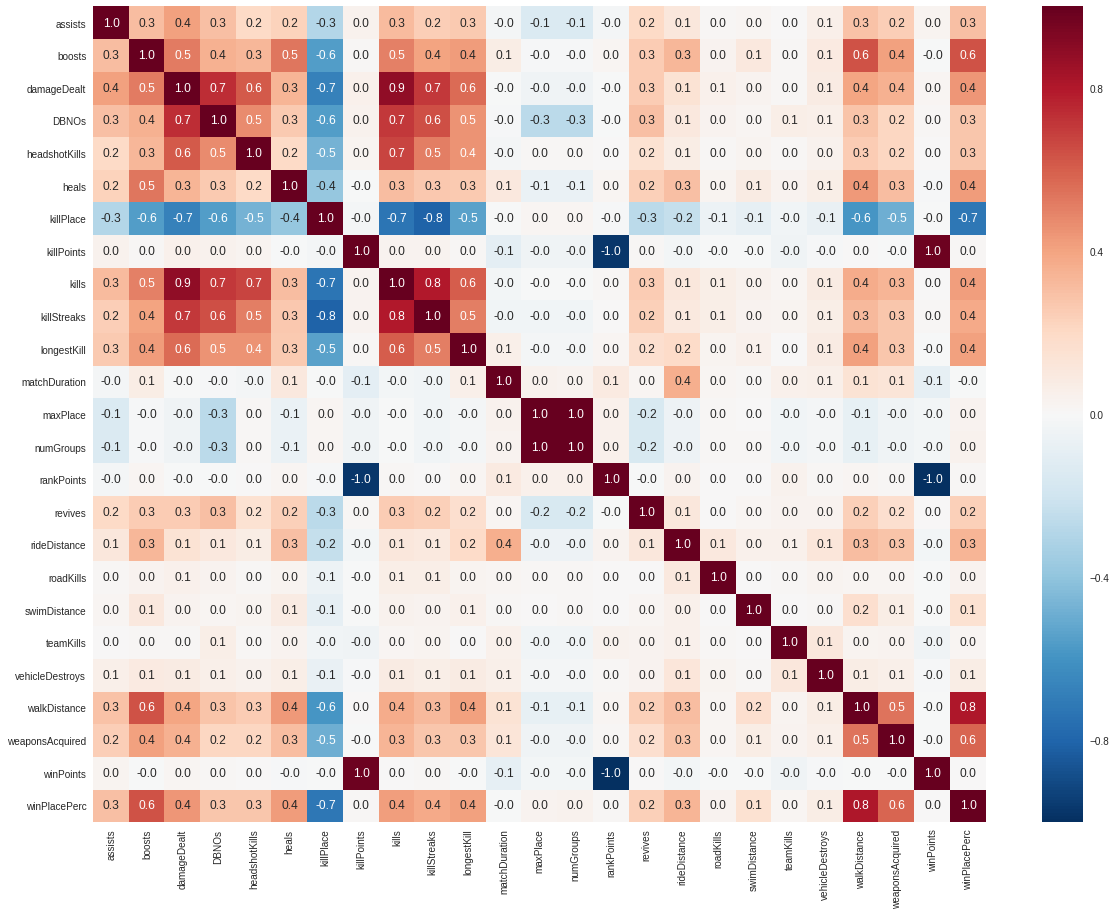

In [0]:
plt.figure(figsize = (20, 15))
sns.heatmap(train.corr(), annot = True, fmt='.1f')
plt.show()

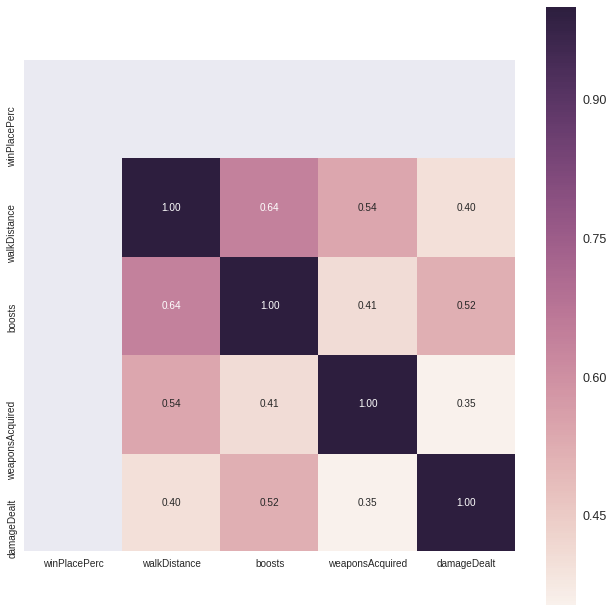

In [0]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


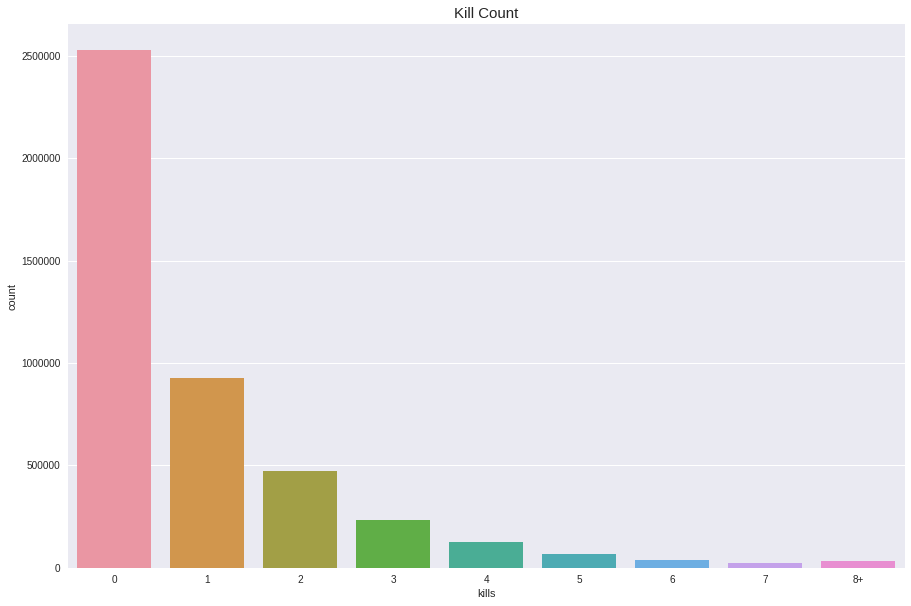

In [0]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


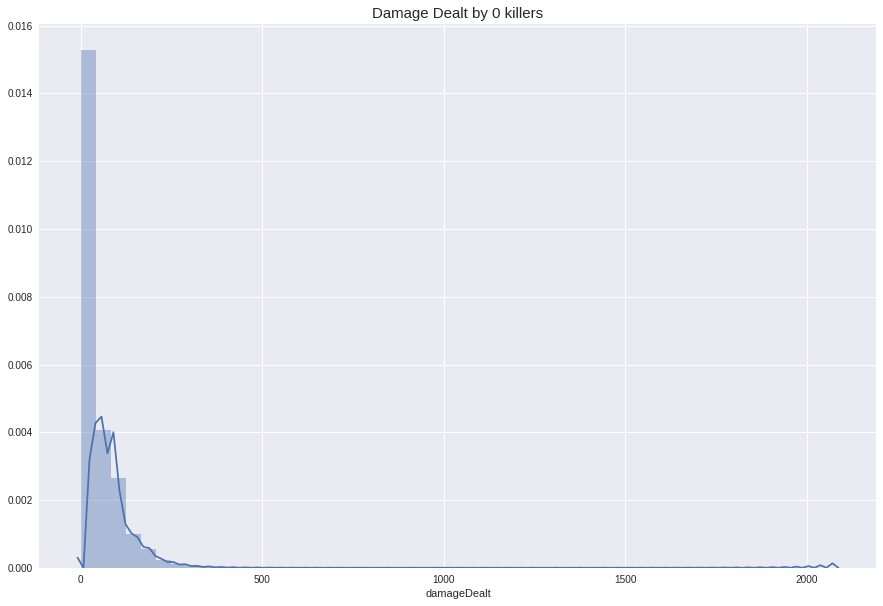

In [0]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


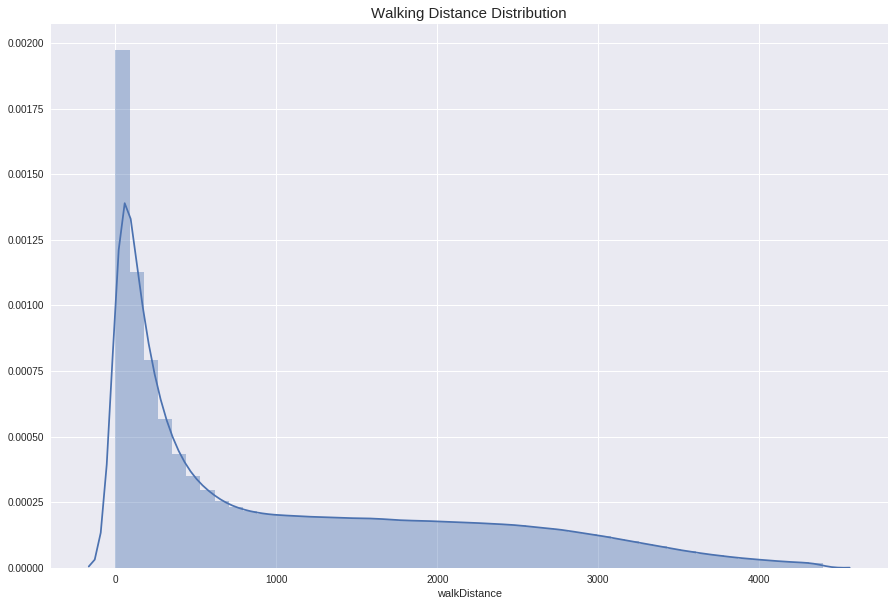

In [0]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

#Step 4 - XGBoost

In [0]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [0]:
matchTyp = ['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo']
mapping = {}
for i, j in enumerate(matchTyp):
    mapping[i] = j
train["matchTypeMap"] = train["matchType"].apply(lambda x: ''.join(str(i) for i, j in mapping.items() if x == j)).map(np.int64)
# test_df["matchTypeMap"] = test_df["matchType"].apply(lambda x: ''.join(str(i) for i, j in mapping.items() if x == j)).map(int64)

In [0]:
train.drop(["matchType"], axis =1, inplace=True)
# test_df.drop(["matchType"], axis =1, inplace=True)

In [0]:
train.dropna(inplace = True)
train.isnull().any().any()

False

In [0]:
X = train.drop(["Id", "groupId", "matchId", "winPlacePerc"], axis = 1)
y = train["winPlacePerc"]

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 25 columns):
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
matchTypeMap       int64
dtypes: float64(5), int64(20)
memory usage: 882.1 MB


In [0]:
model = xgboost.XGBRegressor(max_depth=17, gamma=0.3, learning_rate= 0.1)
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.3, learning_rate=0.1, max_delta_step=0,
       max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
model.predict(X)

array([0.41907367, 0.43581063, 0.7827132 , ..., 0.4067796 , 0.9374052 ,
       0.61767036], dtype=float32)

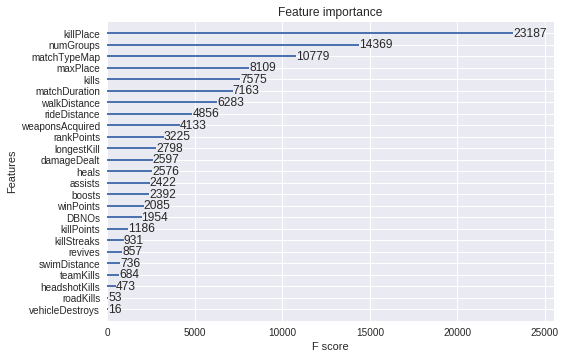

In [0]:
xgboost.plot_importance(model)

In [0]:
pickle.dump(model, open("XGBoost.pickle.dat", "wb"))

In [0]:
from google.colab import files
files.download('XGBoost.pickle.dat')

#Step 5 - ANN

In [0]:
features = list(train.columns)
features.remove("Id")
features.remove("matchId")
features.remove("groupId")
features.remove("matchDuration")
features.remove("matchType")

In [4]:
train.shape

(4446966, 29)

##y

In [0]:
y = np.array(train.groupby(['matchId','groupId'])['winPlacePerc'].agg('mean'), dtype=np.float64)

features.remove("winPlacePerc")

## Group Mean

In [6]:
agg = train.groupby(['matchId','groupId'])[features].agg('mean')
agg.head()

assists  boosts  damageDealt     DBNOs  \
matchId        groupId                                                  
0000a43bce5eec 18b16ec699d8b6      0.0     0.5   109.675000  1.000000   
               236ab9e9c081b9      0.0     0.0    47.988333  0.333333   
               3a6addfa0df938      0.0     0.0     0.000000  0.000000   
               4bf06994bd4c9a      0.0     0.5    11.700000  0.000000   
               4d1bbbc19b9084      1.0     3.5   340.950000  2.500000   

                               headshotKills  heals  killPlace  killPoints  \
matchId        groupId                                                       
0000a43bce5eec 18b16ec699d8b6            0.0    0.5       41.0      1242.0   
               236ab9e9c081b9            0.0    0.0       90.5      1355.5   
               3a6addfa0df938            0.0    0.0       94.5      1382.0   
               4bf06994bd4c9a            0.0    0.0       59.5      1178.0   
               4d1bbbc19b9084            1.0    1.0       14.0      1504.0   

                               kills  killStreaks    ...      rankPoints  \
matchId        groupId                               ...                   
0000a43bce5eec 18b16ec699d8b6    1.0          0.5    ...             0.0   
               236ab9e9c081b9    0.0          0.0    ...             0.0   
               3a6addfa0df938    0.0          0.0    ...             0.0   
               4bf06994bd4c9a    0.0          0.0    ...             0.0   
               4d1bbbc19b9084    3.0          1.5    ...             0.0   

                               revives  rideDistance  roadKills  swimDistance  \
matchId        groupId                                                          
0000a43bce5eec 18b16ec699d8b6      0.0         0.000        0.0         0.000   
               236ab9e9c081b9      0.0         0.000        0.0         0.000   
               3a6addfa0df938      0.0         0.000        0.0         0.000   
               4bf06994bd4c9a      0.0         0.000        0.0         0.000   
               4d1bbbc19b9084      0.0        79.953        0.0         5.576   

                               teamKills  vehicleDestroys  walkDistance  \
matchId        groupId                                                    
0000a43bce5eec 18b16ec699d8b6        0.0              0.0    131.685000   
               236ab9e9c081b9        0.0              0.0     19.931833   
               3a6addfa0df938        0.0              0.0      4.818000   
               4bf06994bd4c9a        0.0              0.0    559.050000   
               4d1bbbc19b9084        0.0              0.0   3292.500000   

                               weaponsAcquired  winPoints  
matchId        groupId                                     
0000a43bce5eec 18b16ec699d8b6         1.000000     1479.0  
               236ab9e9c081b9         0.833333     1464.0  
               3a6addfa0df938         0.500000     1485.0  
               4bf06994bd4c9a         7.000000     1458.0  
               4d1bbbc19b9084         4.000000     1501.0  

[5 rows x 23 columns]

In [7]:
agg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2026745 entries, (0000a43bce5eec, 18b16ec699d8b6) to (fffe92232706aa, d8fa9cfd6f9560)
Data columns (total 23 columns):
assists            float64
boosts             float64
damageDealt        float64
DBNOs              float64
headshotKills      float64
heals              float64
killPlace          float64
killPoints         float64
kills              float64
killStreaks        float64
longestKill        float64
maxPlace           float64
numGroups          float64
rankPoints         float64
revives            float64
rideDistance       float64
roadKills          float64
swimDistance       float64
teamKills          float64
vehicleDestroys    float64
walkDistance       float64
weaponsAcquired    float64
winPoints          float64
dtypes: float64(23)
memory usage: 386.9+ MB


In [8]:
agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
agg_rank.head()

,matchId,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,0000a43bce5eec,18b16ec699d8b6,0.285714,0.446429,0.571429,0.642857,0.339286,0.482143,0.428571,0.285714,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.285714,0.160714,0.357143
1,0000a43bce5eec,236ab9e9c081b9,0.285714,0.160714,0.321429,0.428571,0.339286,0.196429,0.964286,0.678571,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.071429,0.107143,0.142857
2,0000a43bce5eec,3a6addfa0df938,0.285714,0.160714,0.071429,0.142857,0.339286,0.196429,1.000000,0.750000,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.035714,0.035714,0.571429
3,0000a43bce5eec,4bf06994bd4c9a,0.285714,0.446429,0.142857,0.142857,0.339286,0.196429,0.785714,0.178571,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.392857,1.000000,0.107143
4,0000a43bce5eec,4d1bbbc19b9084,0.892857,0.857143,0.857143,0.857143,0.964286,0.553571,0.196429,0.928571,...,0.517857,0.339286,0.821429,0.517857,0.892857,0.5,0.482143,0.964286,0.625000,0.785714


In [9]:
agg_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026745 entries, 0 to 2026744
Data columns (total 25 columns):
matchId            object
groupId            object
assists            float64
boosts             float64
damageDealt        float64
DBNOs              float64
headshotKills      float64
heals              float64
killPlace          float64
killPoints         float64
kills              float64
killStreaks        float64
longestKill        float64
maxPlace           float64
numGroups          float64
rankPoints         float64
revives            float64
rideDistance       float64
roadKills          float64
swimDistance       float64
teamKills          float64
vehicleDestroys    float64
walkDistance       float64
weaponsAcquired    float64
winPoints          float64
dtypes: float64(23), object(2)
memory usage: 386.6+ MB


In [10]:
df_out = agg.reset_index()[['matchId','groupId']]
df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
df_out.head()

,matchId,groupId,assists_mean,boosts_mean,damageDealt_mean,DBNOs_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,...,rankPoints_mean_rank,revives_mean_rank,rideDistance_mean_rank,roadKills_mean_rank,swimDistance_mean_rank,teamKills_mean_rank,vehicleDestroys_mean_rank,walkDistance_mean_rank,weaponsAcquired_mean_rank,winPoints_mean_rank
0,0000a43bce5eec,18b16ec699d8b6,0.0,0.5,109.675000,1.000000,0.0,0.5,41.0,1242.0,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.285714,0.160714,0.357143
1,0000a43bce5eec,236ab9e9c081b9,0.0,0.0,47.988333,0.333333,0.0,0.0,90.5,1355.5,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.071429,0.107143,0.142857
2,0000a43bce5eec,3a6addfa0df938,0.0,0.0,0.000000,0.000000,0.0,0.0,94.5,1382.0,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.035714,0.035714,0.571429
3,0000a43bce5eec,4bf06994bd4c9a,0.0,0.5,11.700000,0.000000,0.0,0.0,59.5,1178.0,...,0.517857,0.339286,0.375000,0.517857,0.410714,0.5,0.482143,0.392857,1.000000,0.107143
4,0000a43bce5eec,4d1bbbc19b9084,1.0,3.5,340.950000,2.500000,1.0,1.0,14.0,1504.0,...,0.517857,0.339286,0.821429,0.517857,0.892857,0.5,0.482143,0.964286,0.625000,0.785714


In [11]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2026745 entries, 0 to 2026744
Data columns (total 48 columns):
matchId                      object
groupId                      object
assists_mean                 float64
boosts_mean                  float64
damageDealt_mean             float64
DBNOs_mean                   float64
headshotKills_mean           float64
heals_mean                   float64
killPlace_mean               float64
killPoints_mean              float64
kills_mean                   float64
killStreaks_mean             float64
longestKill_mean             float64
maxPlace_mean                float64
numGroups_mean               float64
rankPoints_mean              float64
revives_mean                 float64
rideDistance_mean            float64
roadKills_mean               float64
swimDistance_mean            float64
teamKills_mean               float64
vehicleDestroys_mean         float64
walkDistance_mean            float64
weaponsAcquired_mean         float64
w

## Group Max

In [0]:
agg = train.groupby(['matchId','groupId'])[features].agg('max')
agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()

df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])

In [13]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2026745 entries, 0 to 2026744
Data columns (total 94 columns):
matchId                      object
groupId                      object
assists_mean                 float64
boosts_mean                  float64
damageDealt_mean             float64
DBNOs_mean                   float64
headshotKills_mean           float64
heals_mean                   float64
killPlace_mean               float64
killPoints_mean              float64
kills_mean                   float64
killStreaks_mean             float64
longestKill_mean             float64
maxPlace_mean                float64
numGroups_mean               float64
rankPoints_mean              float64
revives_mean                 float64
rideDistance_mean            float64
roadKills_mean               float64
swimDistance_mean            float64
teamKills_mean               float64
vehicleDestroys_mean         float64
walkDistance_mean            float64
weaponsAcquired_mean         float64
w

## Group Min

In [0]:
agg = train.groupby(['matchId','groupId'])[features].agg('min')
agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()

df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])

## Group size

In [0]:
agg = train.groupby(['matchId','groupId']).size().reset_index(name='group_size')

df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])

## Match Mean

In [0]:
agg = train.groupby(['matchId'])[features].agg('mean').reset_index()

df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

## Match Size

In [0]:
agg = train.groupby(['matchId']).size().reset_index(name='match_size')

df_out = df_out.merge(agg, how='left', on=['matchId'])

##X

In [0]:
df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
X = np.array(df_out, dtype=np.float64)
del agg, agg_rank, df_out

## Scaler

In [19]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=False).fit(X)
scaler.transform(X)

array([[0.        , 0.01515152, 0.01657724, ..., 0.03855248, 0.95486716,
        0.94949495],
       [0.        , 0.        , 0.00725338, ..., 0.03855248, 0.95486716,
        0.94949495],
       [0.        , 0.        , 0.        , ..., 0.03855248, 0.95486716,
        0.94949495],
       ...,
       [0.        , 0.        , 0.00392231, ..., 0.0494967 , 0.        ,
        0.92929293],
       [0.        , 0.01515152, 0.00903114, ..., 0.0494967 , 0.        ,
        0.92929293],
       [0.00649351, 0.03896104, 0.01578209, ..., 0.0494967 , 0.        ,
        0.92929293]])

## Train Test Splitt

In [20]:
X.shape

(2026745, 163)

In [21]:
y.shape

(2026745,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Model

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import regularizers
from keras.layers import Dropout
import tensorflow as tf
import keras

Using TensorFlow backend.


In [24]:
with tf.device('/gpu:0'):
  model = Sequential()
#   model.add(Dense(500,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#   model.add(Dense(200,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#   model.add(Dense(100,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#   model.add(Dense(200,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#   model.add(Dense(500,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  
  model.add(Dense(163,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(0.001)))

#   model.add(Dense(32,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#   model.add(Dense(16,activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(1, activation='relu'))
  adam = keras.optimizers.Adam(lr=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
  model.compile(loss=keras.losses.mean_absolute_error , optimizer=adam, metrics = ['mae', 'acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
with tf.device('/gpu:0'):
  model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1621396 samples, validate on 405349 samples
Epoch 1/30
1621396/1621396 [==============================] - 46s 28us/step - loss: nan - mean_absolute_error: nan - acc: 0.0471 - val_loss: 0.0435 - val_mean_absolute_error: 0.0361 - val_acc: 0.0470
Epoch 2/30
1621396/1621396 [==============================] - 43s 27us/step - loss: nan - mean_absolute_error: nan - acc: 0.0473 - val_loss: 0.0410 - val_mean_absolute_error: 0.0352 - val_acc: 0.0470
Epoch 3/30
1621396/1621396 [==============================] - 43s 27us/step - loss: nan - mean_absolute_error: nan - acc: 0.0473 - val_loss: 0.0408 - val_mean_absolute_error: 0.0355 - val_acc: 0.0470
Epoch 4/30
1621396/1621396 [==============================] - 44s 27us/step - loss: nan - mean_absolute_error: nan - acc: 0.0473 - val_loss: 0.0387 - val_mean_absolute_error: 0.0335 - val_acc: 0.0470
Epoch 5/30
1621396/1621396 [==============================] - 51s 32us/step - loss: nan - mean_abso

In [26]:
mean_absolute_error(y_test, model.predict(X_test))

0.03368327339271403